In [3]:
import pymc3 as pm3
import numpy as np
import numdifftools as ndt
import pandas as pd
from scipy.stats import norm, beta
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.optimize import minimize
import matplotlib.pyplot as plt

About Log likelihood estimation : https://rlhick.people.wm.edu/posts/estimating-custom-mle.html

In [4]:
N = 10000
h1 = 4 + np.random.randn(N)
d1 = 5 + np.random.randn(N)

sigma = 3 + .2 * h1

d2 = 3 + 5 * h1 - 2 * d1 + 3 * h1 * d1 + sigma * np.random.randn(N)

df = pd.DataFrame({'d2': d2, 'h1' : h1, 'd1' : d1, 'h1d1': h1 * d1})
df['constant'] = 1

df.head()

,d2,h1,d1,h1d1,constant
0,52.861402,3.773954,4.180859,15.778370,1
1,72.975885,3.269980,5.896433,19.281216,1
2,108.316469,4.777319,6.564492,31.360673,1
3,94.404121,5.818637,3.986532,23.196183,1
4,58.943895,3.561403,4.155680,14.800052,1


In [5]:
def _ll_ols(y, X, beta, gamma):
    mu = X.dot(beta)
    sigma = X[:,:2].dot(gamma)
    return norm(mu,sigma).logpdf(y).sum()    


In [6]:
class MyDepNormML(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(MyDepNormML, self).__init__(endog, exog, **kwds)
    def nloglikeobs(self, params):
        gamma = params[-2:]
        beta = params[:-2]
        ll = _ll_ols(self.endog, self.exog, beta, gamma)
        return -ll
    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
        # we have one additional parameter and we need to add it for summary
        self.exog_names.append('gamm1')
        self.exog_names.append('gamm2')
        if start_params == None:
            # Reasonable starting values
            start_params = np.append(np.zeros(self.exog.shape[1]), [0.5,.5])
        return super(MyDepNormML, self).fit(start_params=start_params, 
                                  maxiter=maxiter, maxfun=maxfun, 
                                  **kwds)

In [7]:
sm_ml_manual = MyDepNormML(df.d2,df[['constant','h1', 'd1', 'h1d1']]).fit(start_params = [2, 4, -1, 5, 4, 4])
print(sm_ml_manual.summary())

Optimization terminated successfully.
         Current function value: 2.767274
         Iterations: 402
         Function evaluations: 640
                             MyDepNormML Results                              
Dep. Variable:                     d2   Log-Likelihood:                -27673.
Model:                    MyDepNormML   AIC:                         5.535e+04
Method:            Maximum Likelihood   BIC:                         5.538e+04
Date:                Wed, 15 Dec 2021                                         
Time:                        15:02:26                                         
No. Observations:               10000                                         
Df Residuals:                    9996                                         
Df Model:                           3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

In [8]:
# the fitted coefficients:
sm_ols_manual.params


NameError: name 'sm_ols_manual' is not defined

## CTH  - beta distribution

In [9]:
def _ll_beta(y, X, alpha1, beta1, alpha2, beta2, p):
    B1 = beta(alpha1, beta1).pdf(y)
    B2 = beta(alpha2, beta2).pdf(y)    
    if p < 0: 
        p = 0
    elif p > 1: 
        p = 1
    H = p * B1 + (1 - p) * B2
    return np.log(H).sum()    

class MyMixBetaML(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(MyMixBetaML, self).__init__(endog, exog, **kwds)
    def nloglikeobs(self, params):
        alpha1, beta1 = params[:2]
        alpha2, beta2 = params[2:4]
        p = params[4]

        ll = _ll_beta(self.endog, self.exog, alpha1, beta1, alpha2, beta2, p)
        return -ll
    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
        # we have one additional parameter and we need to add it for summary
        self.exog_names.remove('x1')
        self.exog_names.append('alpha1')
        self.exog_names.append('beta1')
        self.exog_names.append('alpha2')
        self.exog_names.append('beta2')
        self.exog_names.append('p')
        if start_params == None:
            # Reasonable starting values
            start_params = np.append(np.zeros(self.exog.shape[1]), [0.5])
        return super(MyMixBetaML, self).fit(start_params=start_params, 
                                  maxiter=maxiter, maxfun=maxfun, 
                                  **kwds)

In [10]:
x = np.arange(0,10)
(x <= 1).any()

True

In [11]:
n = 100
print(n)
x = np.random.rand(n)
# n = int(1e4)
# x = x.sample(int(1e4))

true_params = np.array([ 0.91317788,  1.91077191, 21.52071485,  6.85876098,  0.79635204])
alpha1, beta1, alpha2, beta2, p = true_params

p = 1
alpha1, beta1 = 1, 100
alpha2, beta2 = 2, 1

y1 = beta.rvs(alpha1, beta1, size=n)
y2 = beta.rvs(alpha2, beta2, size=n)
u = (x < p)

y = u * y1 + ~u * y2
# y = np.array([0.11015574, 0.09261799, 0.07746064, 0.06960731, 0.06590445,
#        0.71061019, 0.08488673, 0.11015574, 0.06389025, 0.11571004])
sm_ml_manual = MyMixBetaML(y,y).fit(start_params = [1, 1, 1, 1, 0.5])
print(sm_ml_manual.summary())

    


100
Optimization terminated successfully.
         Current function value: -3.748690
         Iterations: 187
         Function evaluations: 325
                             MyMixBetaML Results                              
Dep. Variable:                      y   Log-Likelihood:                 374.87
Model:                    MyMixBetaML   AIC:                            -747.7
Method:            Maximum Likelihood   BIC:                            -745.1
Date:                Wed, 15 Dec 2021                                         
Time:                        15:02:30                                         
No. Observations:                 100                                         
Df Residuals:                      99                                         
Df Model:                           0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

C:\Users\nerin\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\nerin\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [12]:
sm_ml_manual = MyMixBetaML(y,y).fit(start_params = [1, 1, 1, 1, 0.5])
print(sm_ml_manual.summary())
sm_ml_manual.mle_retvals

Optimization terminated successfully.
         Current function value: -3.748690
         Iterations: 187
         Function evaluations: 325
                             MyMixBetaML Results                              
Dep. Variable:                      y   Log-Likelihood:                 374.87
Model:                    MyMixBetaML   AIC:                            -747.7
Method:            Maximum Likelihood   BIC:                            -745.1
Date:                Wed, 15 Dec 2021                                         
Time:                        15:02:31                                         
No. Observations:                 100                                         
Df Residuals:                      99                                         
Df Model:                           0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

C:\Users\nerin\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


{'fopt': -3.7486900376216186,
 'iterations': 187,
 'fcalls': 325,
 'warnflag': 0,
 'converged': True}

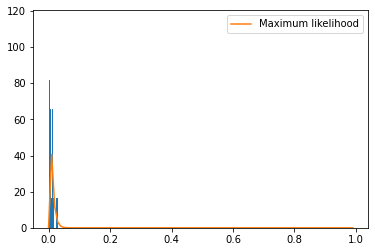

array([  7.64958087,  65.86897041,   1.20524819, 136.38032854,
         0.        ])

In [14]:
sm_ml_manual.params
plt.hist(y, bins = 50, density = True)


def pdf_bmix(y, alpha1, beta1, alpha2, beta2, p):
    B1 = beta(alpha1, beta1).pdf(y)
    B2 = beta(alpha2, beta2).pdf(y)
    H = p * B1 + (1 - p) * B2
    return H

x = np.arange(0, 1, .01)
p = sm_ml_manual.params[-1]
if p > 1:
    p = 1
elif p < 0:
    p = 0
sm_ml_manual.params[-1] = p


# p = 1
# mu = .1
# nu = 100
# alpha1, beta1 = mu * nu, nu - mu * nu
# alpha2, beta2 = 2, 1

plt.plot(x, pdf_bmix(x, *sm_ml_manual.params), label = 'Maximum likelihood')
# plt.plot(x, pdf_bmix(x, alpha1, beta1, alpha2, beta2, p), 'r', label = 'True distribution')
plt.legend()
plt.show()

sm_ml_manual.params

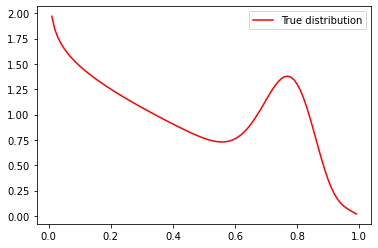

In [22]:
params = np.array([ 0.91317788,  1.91077191, 21.52071485,  6.85876098,  0.79635204])
plt.plot(x, pdf_bmix(x, *params), 'r', label = 'True distribution')
plt.legend()
plt.show()

In [23]:
pdf_bmix(x, *params)[1:].sum() * (x[1] - x[0])

0.9883018840058426

### how many points do I need for accuracy


In [24]:
import time
import timeit

N = np.array([100, 300,1e3, 3e3, 1e4, 3e4, 1e5, 3e5])
true_params = np.array([ 0.91317788,  1.91077191, 21.52071485,  6.85876098,  0.79635204])

def sample(n, params = true_params):
    np.random.seed(0)
    x = np.random.rand(n)
    
    alpha1, beta1, alpha2, beta2, p = true_params

    y1 = beta.rvs(alpha1, beta1, size=n)
    y2 = beta.rvs(alpha2, beta2, size=n)
    u = x < p

    y = u * y1 + ~u * y2
    return y

def mlEstimation(y):
    return MyMixBetaML(y,y).fit(start_params = [1, 1, 1, 1, .5]).params

err = np.zeros((len(N),len(true_params)))
t = np.zeros(len(N))
for i, n in zip(range(len(N)), N):
    y = sample(int(n))
    
    tic = timeit.default_timer()
    est = mlEstimation(y)
    toc = timeit.default_timer()
    t[i] = toc - tic
    
    err[i, :] = np.abs(true_params - est)

    


Optimization terminated successfully.
         Current function value: -0.105349
         Iterations: 165
         Function evaluations: 272


C:\Users\nerin\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.
         Current function value: -0.102298
         Iterations: 349
         Function evaluations: 566
Optimization terminated successfully.
         Current function value: -0.131041
         Iterations: 508
         Function evaluations: 817
Optimization terminated successfully.
         Current function value: -0.125417
         Iterations: 525
         Function evaluations: 846
Optimization terminated successfully.
         Current function value: -0.114355
         Iterations: 586
         Function evaluations: 934
Optimization terminated successfully.
         Current function value: -0.106505
         Iterations: 494
         Function evaluations: 794
Optimization terminated successfully.
         Current function value: -0.111059
         Iterations: 490
         Function evaluations: 778


KeyboardInterrupt: 

In [ ]:
plt.plot(N, err)
plt.plot(N, t)
plt.xscale('log')
plt.yscale('log')
plt.legend([    'alpha1', 'beta1', 'alpha2', 'beta2', 'p', 't'])

In [ ]:
def _ll_beta(y, X, alpha1, beta1):
    B = beta(alpha1, beta1)
    return B.logpdf(y).sum()    

def pdf_b(y, alpha1, beta1):
    B = beta(alpha1, beta1).pdf(y)
    return B


class MyBetaML(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(MyBetaML, self).__init__(endog, exog, **kwds)
    def nloglikeobs(self, params):
        alpha, beta = params
        ll = _ll_beta(self.endog, self.exog, alpha, beta)
        return -ll
    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
        # we have one additional parameter and we need to add it for summary
        self.exog_names.pop()
        self.exog_names.append('alpha')
        self.exog_names.append('beta')                               
        if start_params == None:
            # Reasonable starting values
            start_params = np.append([1,1])
        return super(MyBetaML, self).fit(start_params=start_params, 
                                  maxiter=maxiter, maxfun=maxfun, 
                                  **kwds)
    
    

y = np.array([0.11015574, 0.09261799, 0.07746064, 0.06960731, 0.06590445,
       0.71061019, 0.08488673, 0.11015574, 0.06389025, 0.11571004])
plt.hist(y, bins = 50, density = True)

sm_ml_manual = MyBetaML(y,y).fit(start_params = [1, 1])
print(sm_ml_manual.summary())

x = np.arange(0, 1, .01)

plt.plot(x, pdf_b(x, *sm_ml_manual.params), label = 'Maximum likelihood')
# plt.plot(x, pdf_bmix(x, alpha1, beta1, alpha2, beta2, p), 'r', label = 'True distribution')
plt.legend()
plt.show()

sm_ml_manual.params

In [ ]:
pdf = pdf_b(x, *sm_ml_manual.params)
pdf.sum()